# Classification of synapses

In this jupyter notebook, we provide an example of how to extract explainable features and run a classification for the imaging flow cytometry dataset provided by:

scifAI: An explainable AI python framework for the analysis of multi-channel imaging flow cytometry data


We assume you have already installed the library. Otherwise you can install it using 

`!pip -q install <Path to the cloned module>`

This notebook provides an example for deep learning methods

here we import a series of needed modules. 

In [1]:
import scifAI
import numpy as np
from sklearn.datasets import make_classification
import torch.nn as nn
from skorch import NeuralNetClassifier
import matplotlib.pyplot as plt
import glob
from imageio import imread
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
from tqdm import tqdm
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import torch
from torchvision import transforms
from IPython.core.debugger import Tracer
from torch.utils.data import DataLoader, Dataset
from sklearn.pipeline import Pipeline, FeatureUnion
# Compare Algorithms
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import f1_score

In [2]:
from scifAI.dl.utils import calculate_weights, train_validation_test_split
from scifAI.dl.dataset import DatasetGenerator
from scifAI.dl.custom_transforms import ShuffleChannel
from scifAI.dl.models import PretrainedModel, resnet18

In [3]:
from iflai.dl.models import PretrainedModel
from skorch.callbacks import LRScheduler,Checkpoint,EpochScoring,EarlyStopping
import torch.optim as optim
from skorch.helper import predefined_split

here, we provide a function for visualizing the result of the confusion matrix which will be used later.

In [4]:
from sklearn.metrics import (plot_confusion_matrix, 
                             matthews_corrcoef, 
                             classification_report,
                             confusion_matrix, 
                             accuracy_score, 
                             balanced_accuracy_score, 
                             cohen_kappa_score, 
                             f1_score,  
                             precision_score, recall_score)
from imblearn.metrics import classification_report_imbalanced

def classification_complete_report(y_true, y_pred, plot = True ): 
    print(classification_report(y_true, y_pred))
    print(15*"----")
    print("matthews correlation coeff: %.2f" % (matthews_corrcoef(y_true, y_pred)) )
    print("Cohen Kappa score: %.2f" % (cohen_kappa_score(y_true, y_pred)) )
    print("Accuracy: %.2f & balanced Accuracy: %.2f" % (accuracy_score(y_true, y_pred), balanced_accuracy_score(y_true, y_pred)) )
    print("macro F1 score: %.2f & micro F1 score: %.2f" % (f1_score(y_true, y_pred, average = "macro"), f1_score(y_true, y_pred, average = "micro")) )
    print("macro Precision score: %.2f & micro Precision score: %.2f" % (precision_score(y_true, y_pred, average = "macro"), precision_score(y_true, y_pred, average = "micro")) )
    print("macro Recall score: %.2f & micro Recall score: %.2f" % (recall_score(y_true, y_pred, average = "macro"), recall_score(y_true, y_pred, average = "micro")) )
    print(15*"----")
    
    

now lets calculate the metadata:

In [5]:
%%time

metadata = pd.read_csv("/pstore/data/DS4/synapse_data_features/metadata_subset.csv.gz")

CPU times: user 1.93 s, sys: 261 ms, total: 2.19 s
Wall time: 2.2 s


In [6]:
row_index = metadata.set.isin(["train","validation","test"]) 

metadata = metadata.loc[row_index,:].reset_index(drop = True)

metadata

,file,experiment,donor,condition,object_number,set,label
0,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,4147,train,B_cell
1,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,57117,train,B_T_cell_in_one_layer
2,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,48521,test,B_T_cell_in_one_layer
3,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,30947,train,Multiplets
4,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,38634,train,B_cell
...,...,...,...,...,...,...,...
5216,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,-SEA,22111,train,Multiplets
5217,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,-SEA,28850,validation,No_cell_cell_interaction
5218,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,-SEA,11855,test,T_cell_with_signaling
5219,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,-SEA,18171,train,No_cell_cell_interaction


In [7]:
metadata

,file,experiment,donor,condition,object_number,set,label
0,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,4147,train,B_cell
1,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,57117,train,B_T_cell_in_one_layer
2,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,48521,test,B_T_cell_in_one_layer
3,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,30947,train,Multiplets
4,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,38634,train,B_cell
...,...,...,...,...,...,...,...
5216,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,-SEA,22111,train,Multiplets
5217,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,-SEA,28850,validation,No_cell_cell_interaction
5218,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,-SEA,11855,test,T_cell_with_signaling
5219,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,-SEA,18171,train,No_cell_cell_interaction


['B_cell' 'B_T_cell_in_one_layer' 'Multiplets' 'Synapses_with_signaling'
 'T_cell_with_B_cell_fragments' 'T_cell' 'No_cell_cell_interaction'
 'Synapses_without_signaling' 'T_cell_with_signaling']


<AxesSubplot:>

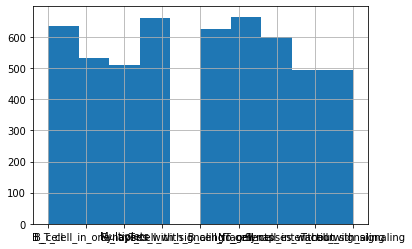

In [8]:
print(metadata.label.unique())
metadata.label.hist()

so we have 31280  files with various labels. first we need to get rid of `unknown` labels

In [9]:
row_index = metadata.label != "unknown"

metadata = metadata.loc[row_index,:].reset_index(drop = True)

lets plot a random image per class

In [10]:
from skimage.util import crop
import h5py

def crop_pad_h_w(image_dummy,reshape_size):
    if image_dummy.shape[0] < reshape_size:
        h1_pad = ( reshape_size - image_dummy.shape[0])/2
        h1_pad = int(h1_pad)
        h2_pad =  reshape_size - h1_pad - image_dummy.shape[0]
        h1_crop = 0
        h2_crop = 0
    else:
        h1_pad = 0
        h2_pad = 0
        h1_crop = ( reshape_size - image_dummy.shape[0])/2
        h1_crop = abs(int(h1_crop))
        h2_crop = image_dummy.shape[0]- reshape_size  - h1_crop

    if image_dummy.shape[1] < reshape_size:
        w1_pad = (reshape_size - image_dummy.shape[1])/2
        w1_pad = int(w1_pad)
        w2_pad = reshape_size - w1_pad - image_dummy.shape[1]
        w1_crop = 0
        w2_crop = 0
    else:
        w1_pad = 0
        w2_pad = 0
        w1_crop = (reshape_size - image_dummy.shape[1])/2
        w1_crop = abs(int(w1_crop))
        w2_crop = image_dummy.shape[1]- reshape_size  - w1_crop

    h = [h1_crop, h2_crop, h1_pad, h2_pad]
    w = [w1_crop, w2_crop, w1_pad, w2_pad] 
    return h, w


Set all random seeds to the specific value, so the results are more reproducable

In [11]:
seed_value = 42

os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)

np.random.seed(seed_value)
torch.manual_seed(seed_value)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Define all necessary parameters

In [12]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [13]:

model_dir = "models"
log_dir = "logs"
scaling_factor = 4095.
reshape_size = 160
train_transform = [
        transforms.RandomResizedCrop(reshape_size, scale=(0.6, 1.0), ratio=(0.8, 1.2)),
         transforms.RandomHorizontalFlip(),
         transforms.RandomVerticalFlip(),
         AddGaussianNoise(mean=0., std=0.005),
        ]
test_transform = [ ]
num_classes = len(metadata.label.unique())

In [14]:

channels = np.asarray(["BF","Antibody","CD18","F-Actin","MHCII","CD3","P-CD3zeta","Live-Dead"])
selected_channels = np.arange(len(channels))
num_channels = len(selected_channels)
num_of_all_channels = len(channels)
all_channels = np.arange(num_of_all_channels)

In [15]:
batch_size = 128
num_workers = 4
device="cuda"

In [16]:
channel_importance = pd.read_csv("channel_importance.csv")
channel_importance

,fold,channel,PXPermute,DeepLift,LRP,GuidedGradCAM,IntegratedGradients
0,1,BF,-0.903509,5.130000e-05,881.029748,-8.440000e-09,3.560000e-05
1,1,Antibody,-0.875932,7.140000e-06,39.048419,-6.990000e-09,1.760000e-06
2,1,CD18,-0.891383,3.430000e-06,-58.621100,-9.480000e-09,2.070000e-06
3,1,F-Actin,-0.853113,2.640000e-06,-188.193848,-3.980000e-09,1.860000e-06
4,1,MHCII,-0.683771,-1.320000e-06,-93.692622,-7.710000e-09,-6.530000e-07
5,1,CD3,-0.670556,-1.390000e-06,42.120468,-1.530000e-08,2.070000e-06
6,1,P-CD3zeta,-0.647172,2.840000e-06,-522.217394,3.050000e-10,1.680000e-06
7,1,Live-Dead,-0.909705,8.390000e-06,12.706195,-8.140000e-10,5.830000e-06
8,2,BF,0.000334,1.560000e-05,-10.388792,9.190000e-09,1.940000e-05
9,2,Antibody,0.065707,7.200000e-06,-2.661150,1.930000e-09,7.070000e-06


In [17]:
from sklearn.preprocessing import MinMaxScaler
interpretation_methods = ["PXPermute", "DeepLift", "LRP", "GuidedGradCAM","IntegratedGradients"]
channel_importance.loc[:, interpretation_methods] = MinMaxScaler().fit_transform(channel_importance.loc[:, interpretation_methods])



<AxesSubplot:xlabel='variable', ylabel='value'>

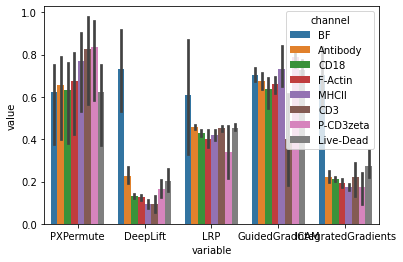

In [18]:
import seaborn as sns
sns.barplot(data = pd.melt(channel_importance, id_vars=["fold","channel"]), 
            x = "variable", 
            y = "value",
            hue = "channel")

In [19]:
channel_importance.channel.unique()

array(['BF', 'Antibody', 'CD18', 'F-Actin', 'MHCII', 'CD3', 'P-CD3zeta',
       'Live-Dead'], dtype=object)

In [20]:
channel_map = {
    'BF':"Ch0", 
    'Antibody':"Ch1", 
    'CD18':"Ch2", 
    'F-Actin':"Ch3", 
    'MHCII':"Ch4", 
    'CD3':"Ch5", 
    'P-CD3zeta':"Ch6",
    'Live-Dead':"Ch7"
}

channel_importance.channel = channel_importance.channel.replace(channel_map)

<AxesSubplot:xlabel='variable', ylabel='value'>

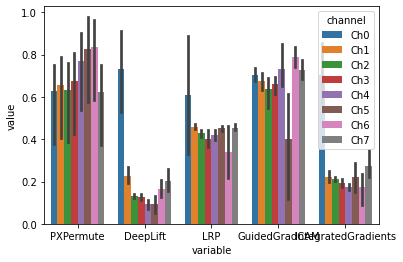

In [21]:
import seaborn as sns
sns.barplot(data = pd.melt(channel_importance, id_vars=["fold","channel"]), 
            x = "variable", 
            y = "value",
            hue = "channel")

In [22]:
def select_top_channels(channel_importance, method, num_top_channels):
    grouped_importance = channel_importance.loc[:,["channel",method]].groupby("channel").mean()
    grouped_importance = grouped_importance.sort_values(by=method, ascending = False) 
    selected_channels = grouped_importance.index[:num_top_channels]
    selected_channels = [int(ch.replace("Ch","")) for ch in selected_channels]
    return selected_channels

In [23]:
def get_statistics(dataloader, selected_channels):
    nmb_channels = len(selected_channels)

    statistics = dict()
    statistics["p01"] = torch.zeros(nmb_channels)
    statistics["p99"] = torch.zeros(nmb_channels)
    for _, data_l in enumerate(tqdm(dataloader), 0):
        image, _ = data_l
        for n in range(nmb_channels):
            statistics["p01"][n] += torch.quantile(image[:, n, :, :], 0.01)
            statistics["p99"][n] += torch.quantile(image[:, n, :, :], 0.99)

    # averaging
    for k in statistics:
        statistics[k] = statistics[k].div_(len(dataloader))

    print('statistics used: %s' % (str(statistics)))

    return statistics

In [24]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)
    
class MinMaxScaler(object):
    def __init__(self, min_in , max_in, min_out, max_out):
        self.min_in = min_in.reshape(-1,1,1)
        self.max_in = max_in.reshape(-1,1,1)
        self.min_out = min_out
        self.max_out = max_out
        
    def __call__(self, tensor):
        
        tensor_ = (tensor - self.min_in)/(self.max_in - self.min_in)
        tensor_ = tensor_*(self.max_out - self.min_out) + self.min_out
        tensor_[tensor_<self.min_out]= self.min_out
        tensor_[tensor_>self.max_out]= self.max_out
        return tensor_
    
    def __repr__(self):
        return self.__class__.__name__ + '(min_out={0}, max_out={1})'.format(self.min_out, self.max_out)

In [25]:

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import torch.nn as nn
from scifAI.dl.models import PretrainedModel
import torch.nn.functional as F

num_top_channels = 3
skf = StratifiedKFold(n_splits=5, random_state=seed_value, shuffle=True)


results_with_best_channels = pd.DataFrame(columns = ["method",
                                                     "f1_micro",
                                                     "f1_macro",
                                                     "accuracy"])

for met in interpretation_methods:
    selected_channels = select_top_channels(channel_importance, met , num_top_channels)
    channels = np.asarray([ "Ch" + str(i) for i in selected_channels])
    
    print(met, selected_channels)
    num_of_all_channels = len(channels)
    all_channels = np.arange(num_of_all_channels)
    for train_index, test_index in skf.split(metadata.index.tolist(), metadata["label"]):
        train_index, validation_index, _, _ = train_test_split(train_index, 
                                                    metadata.loc[train_index,"label"].index.tolist(), 
                                                    stratify = metadata.loc[train_index,"label"].tolist(),
                                                    test_size=0.2, 
                                                    random_state=seed_value)
        label_map = dict(zip(sorted(set(metadata.loc[train_index, "label"])), 
                     np.arange(len(set(metadata.loc[train_index, "label"])))))

        set_of_interesting_classes = metadata.label.unique().tolist()

        num_classes = len(metadata.label.unique())
        
        train_dataset = DatasetGenerator(metadata=metadata.loc[train_index,:],
                                 label_map=label_map,
                                 selected_channels=selected_channels,
                                 scaling_factor=scaling_factor,
                                 reshape_size=reshape_size,
                                 transform=transforms.Compose([ ] ))
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
        statistics = get_statistics(train_loader, selected_channels=selected_channels)
        
        stats = dict()
        stats["lower_bound"] = torch.tensor([statistics['p01'][0], 
                                             statistics['p01'][1], 
                                             statistics['p01'][2]])

        stats["upper_bound"] = torch.tensor([statistics['p99'][0], 
                                             statistics['p99'][1], 
                                             statistics['p99'][2]])

        train_transform = [ 
                MinMaxScaler(           min_in =  stats["lower_bound"] , 
                                        max_in =  stats["upper_bound"] , 
                                        min_out =  0. , 
                                        max_out =  1.),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                AddGaussianNoise(mean=0., std=0.01),
        ]

        validation_transform =  [ 
                MinMaxScaler(           min_in =  stats["lower_bound"] , 
                                        max_in =  stats["upper_bound"] , 
                                        min_out =  0. , 
                                        max_out =  1.),
        ]

        test_transform =  [ 
                MinMaxScaler(           min_in =  stats["lower_bound"] , 
                                        max_in =  stats["upper_bound"] , 
                                        min_out =  0. , 
                                        max_out =  1.),
        ]
        
        train_dataset = DatasetGenerator(metadata=metadata.loc[train_index,:],
                                 label_map=label_map,
                                 selected_channels=selected_channels,
                                 scaling_factor=scaling_factor, 
                                 reshape_size=reshape_size,
                                 transform= transforms.Compose(train_transform))

        validation_dataset = DatasetGenerator(metadata=metadata.loc[validation_index,:],
                                              label_map=label_map,
                                              selected_channels=selected_channels,
                                              scaling_factor=scaling_factor,
                                              reshape_size=reshape_size,
                                              transform=transforms.Compose(validation_transform))
        
        test_dataset = DatasetGenerator(metadata=metadata.loc[test_index,:],
                                        label_map=label_map,
                                        selected_channels=selected_channels,
                                        scaling_factor=scaling_factor,
                                        reshape_size=reshape_size,
                                        transform=
                                        transforms.Compose(test_transform))
        
        

        resnet18_modified = PretrainedModel(num_channels = len(selected_channels),
                                             num_classes = len(set_of_interesting_classes), 
                                             pretrained = True)
        
        lr_scheduler = LRScheduler(policy='ReduceLROnPlateau', factor=0.5, patience=5)

        epoch_scoring_f1_micro = EpochScoring("f1_micro", 
                                     name =  "valid_f1_micro", 
                                     on_train = False,
                                     lower_is_better = False)

        epoch_scoring_f1_macro = EpochScoring("f1_macro", 
                                     name =  "valid_f1_macro", 
                                     on_train = False,
                                     lower_is_better = False)

        early_stopping = EarlyStopping(monitor='valid_f1_macro', 
                                       patience=50, 
                                       threshold=0.0001, 
                                       threshold_mode='rel', 
                                       lower_is_better=False)

        checkpoint = Checkpoint(f_params='synapse_formation_DL_method_comparison.pth',
                                monitor='valid_f1_macro_best', load_best=True)
        
        net = NeuralNetClassifier(    
            resnet18_modified, 
            criterion=nn.CrossEntropyLoss,
            lr=0.001,
            batch_size=batch_size,
            max_epochs=1000,
            optimizer=optim.Adam,
            iterator_train__shuffle=True,
            iterator_train__num_workers=num_workers,
            iterator_valid__shuffle=False,
            iterator_valid__num_workers=2,
            callbacks=[lr_scheduler, epoch_scoring_f1_micro, 
                       epoch_scoring_f1_macro, 
                       early_stopping, checkpoint],
            train_split=predefined_split(validation_dataset),
            device="cuda",
            warm_start=True)
        net = net.fit(train_dataset, y = None)
        net.module.load_state_dict(torch.load('synapse_formation_DL_method_comparison.pth')) 
        
        inv_label_map = {v: k for k, v in label_map.items()}

        preds = net.predict(test_dataset)
        preds =  [inv_label_map[int(t)] for t in preds]
        
        results_with_best_channels = results_with_best_channels.append({
            "method":met,
            "f1_micro":f1_score(test_dataset.metadata.label, preds, average="micro"),
            "f1_macro":f1_score(test_dataset.metadata.label, preds, average="macro"),
            "accuracy":accuracy_score(test_dataset.metadata.label, preds),
        },ignore_index = True)
        net = None
        resnet18_modified = None
        torch.cuda.empty_cache()
        print("---------------------------"*3)

PXPermute [6, 5, 4]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


statistics used: {'p01': tensor([0.0087, 0.0115, 0.0085]), 'p99': tensor([0.0113, 0.0872, 0.0719])}
  epoch    train_loss    valid_acc    valid_f1_macro    valid_f1_micro    valid_loss    cp     dur
-------  ------------  -----------  ----------------  ----------------  ------------  ----  ------
      1        0.8832       0.5526            0.4944            0.5526        1.9112     +  7.7581
      2        0.5434       0.6746            0.6335            0.6746        1.1205     +  6.9801
      3        0.4376       0.7823            0.7637            0.7823        0.5969     +  7.1767
      4        0.3436       0.8469            0.8452            0.8469        0.4382     +  6.9280
      5        0.3433       0.8074            0.8024            0.8074        0.4913        6.8157
      6        0.3266       0.7895            0.7831            0.7895        0.6075        6.7818
      7        0.3562       0.7237            0.6860            0.7237        0.9132        6.7890
      8  

     74        0.0031       0.8971            0.8955            0.8971        0.4424        6.7956
     75        0.0047       0.8900            0.8882            0.8900        0.4561        6.7785
     76        0.0096       0.9031            0.9020            0.9031        0.4422     +  6.7583
     77        0.0209       0.8911            0.8875            0.8911        0.5274        6.8476
     78        0.0574       0.8804            0.8777            0.8804        0.5323        6.8323
     79        0.0235       0.8888            0.8866            0.8888        0.5047        6.7900
     80        0.0305       0.8923            0.8907            0.8923        0.4856        6.7647
     81        0.0148       0.8995            0.8976            0.8995        0.4190        6.7598
     82        0.0074       0.8971            0.8948            0.8971        0.4384        6.7684
     83        0.0067       0.9031            0.9013            0.9031        0.4212        6.7477
     84   

100%|██████████| 27/27 [00:22<00:00,  1.22it/s]


statistics used: {'p01': tensor([0.0087, 0.0115, 0.0085]), 'p99': tensor([0.0113, 0.0860, 0.0693])}
  epoch    train_loss    valid_acc    valid_f1_macro    valid_f1_micro    valid_loss    cp     dur
-------  ------------  -----------  ----------------  ----------------  ------------  ----  ------
      1        0.8200       0.5048            0.4381            0.5048        2.9406     +  6.9649
      2        0.5120       0.6483            0.5586            0.6483        1.2620     +  6.8535
      3        0.4048       0.7333            0.7293            0.7333        0.7665     +  6.8253
      4        0.5009       0.6579            0.6376            0.6579        1.1724        6.7765
      5        0.3648       0.8361            0.8304            0.8361        0.4871     +  6.7979
      6        0.3107       0.8589            0.8573            0.8589        0.3902     +  6.7651
      7        0.2929       0.8636            0.8573            0.8636        0.4080        6.7689
      8  

     74        0.0094       0.8792            0.8753            0.8792        0.5291        6.7797
     75        0.0052       0.8864            0.8816            0.8864        0.5147        6.7496
     76        0.0045       0.8888            0.8836            0.8888        0.5297        6.7534
     77        0.0041       0.8888            0.8840            0.8888        0.5273        6.7430
     78        0.0036       0.8911            0.8869            0.8911        0.5392        6.7606
     79        0.0044       0.8804            0.8743            0.8804        0.5548        6.7905
     80        0.0037       0.8864            0.8809            0.8864        0.5537        6.7664
     81        0.0036       0.8864            0.8813            0.8864        0.5456        6.7901
     82        0.0033       0.8911            0.8865            0.8911        0.5475        6.7631
     83        0.0035       0.8876            0.8826            0.8876        0.5568        6.7639
     84   

100%|██████████| 27/27 [00:21<00:00,  1.24it/s]


statistics used: {'p01': tensor([0.0088, 0.0115, 0.0085]), 'p99': tensor([0.0113, 0.0863, 0.0717])}
  epoch    train_loss    valid_acc    valid_f1_macro    valid_f1_micro    valid_loss    cp     dur
-------  ------------  -----------  ----------------  ----------------  ------------  ----  ------
      1        0.8722       0.5622            0.4818            0.5622        2.5125     +  6.9441
      2        0.5172       0.8038            0.7825            0.8038        0.5345     +  6.8378
      3        0.4606       0.7081            0.6811            0.7081        0.8359        6.7868
      4        0.4120       0.8158            0.8101            0.8158        0.5019     +  6.7851
      5        0.3579       0.7727            0.7601            0.7727        0.6563        6.7652
      6        0.3329       0.7919            0.7874            0.7919        0.6194        6.7966
      7        0.3276       0.8457            0.8448            0.8457        0.4408     +  6.7671
      8  

     76        0.0024       0.9043            0.9023            0.9043        0.3930        6.8059
     77        0.0117       0.8876            0.8852            0.8876        0.4279        6.7862
     78        0.0058       0.8995            0.8961            0.8995        0.4037        6.7494
     79        0.0026       0.8959            0.8933            0.8959        0.4366        6.7654
     80        0.0019       0.9019            0.8992            0.9019        0.4099        6.7602
     81        0.0022       0.8983            0.8957            0.8983        0.4249        6.7774
     82        0.0021       0.9079            0.9054            0.9079        0.4127        6.7489
     83        0.0118       0.9019            0.8992            0.9019        0.4161        6.7723
     84        0.0049       0.8983            0.8961            0.8983        0.4128        6.7492
     85        0.0029       0.9019            0.8997            0.9019        0.4035        6.7667
     86   

    157        0.0010       0.9031            0.9004            0.9031        0.4198        6.7740
    158        0.0012       0.9031            0.9004            0.9031        0.4220        6.7849
    159        0.0011       0.9043            0.9018            0.9043        0.4232        6.7671
    160        0.0010       0.9043            0.9012            0.9043        0.4163        6.7662
    161        0.0010       0.9055            0.9030            0.9055        0.4131        6.7550
    162        0.0011       0.9043            0.9014            0.9043        0.4172        6.7728
    163        0.0009       0.9103            0.9076            0.9103        0.4073        6.7593
    164        0.0011       0.9019            0.8991            0.9019        0.4233        6.7784
    165        0.0013       0.9067            0.9042            0.9067        0.4135        6.7873
    166        0.0017       0.9031            0.9002            0.9031        0.4219        6.7413
    167   

100%|██████████| 27/27 [00:21<00:00,  1.23it/s]


statistics used: {'p01': tensor([0.0087, 0.0114, 0.0085]), 'p99': tensor([0.0113, 0.0872, 0.0700])}
  epoch    train_loss    valid_acc    valid_f1_macro    valid_f1_micro    valid_loss    cp     dur
-------  ------------  -----------  ----------------  ----------------  ------------  ----  ------
      1        0.8396       0.6376            0.6311            0.6376        1.5434     +  6.9446
      2        0.4677       0.7177            0.7016            0.7177        0.9039     +  6.8280
      3        0.4753       0.6794            0.6427            0.6794        1.0765        6.7887
      4        0.4330       0.8170            0.8116            0.8170        0.5655     +  6.8016
      5        0.3296       0.8014            0.7871            0.8014        0.5644        6.7576
      6        0.2935       0.8313            0.8241            0.8313        0.6114     +  6.7640
      7        0.2988       0.8660            0.8601            0.8660        0.4507     +  6.7841
      8  

     76        0.0031       0.8900            0.8873            0.8900        0.5139        6.7651
     77        0.0045       0.8947            0.8917            0.8947        0.5033        6.7850
     78        0.0032       0.8923            0.8892            0.8923        0.5246        6.7753
     79        0.0028       0.8911            0.8880            0.8911        0.5400        6.7622
     80        0.0038       0.8935            0.8897            0.8935        0.5324        6.7539
     81        0.0173       0.8816            0.8768            0.8816        0.5719        6.8073
     82        0.0117       0.8995            0.8969            0.8995        0.5010        6.8118
     83        0.0217       0.8888            0.8859            0.8888        0.5694        6.7621
     84        0.0601       0.8708            0.8656            0.8708        0.6312        6.7789
     85        0.0441       0.8780            0.8725            0.8780        0.5956        6.7577
     86   

100%|██████████| 27/27 [00:21<00:00,  1.23it/s]


statistics used: {'p01': tensor([0.0087, 0.0115, 0.0085]), 'p99': tensor([0.0113, 0.0863, 0.0699])}
  epoch    train_loss    valid_acc    valid_f1_macro    valid_f1_micro    valid_loss    cp     dur
-------  ------------  -----------  ----------------  ----------------  ------------  ----  ------
      1        0.7762       0.5754            0.5015            0.5754        2.0429     +  6.9193
      2        0.5020       0.7739            0.7395            0.7739        0.7402     +  6.8336
      3        0.4428       0.8122            0.8086            0.8122        0.5485     +  6.8022
      4        0.3366       0.8074            0.7906            0.8074        0.5854        6.7729
      5        0.3638       0.8002            0.7950            0.8002        0.5962        6.7672
      6        0.3151       0.8409            0.8331            0.8409        0.4803     +  6.7896
      7        0.3253       0.8361            0.8293            0.8361        0.4446        6.7995
      8  

     75        0.0049       0.8756            0.8725            0.8756        0.6165        6.7599
     76        0.0083       0.8684            0.8656            0.8684        0.6114        6.7484
     77        0.0078       0.8720            0.8685            0.8720        0.5889        6.7453
     78        0.0099       0.8732            0.8692            0.8732        0.6056        6.7834
     79        0.0042       0.8684            0.8651            0.8684        0.6028        6.7635
     80        0.0043       0.8756            0.8725            0.8756        0.5910        6.7457
     81        0.0039       0.8768            0.8734            0.8768        0.5857        6.7402
     82        0.0035       0.8780            0.8745            0.8780        0.5912        6.7488
     83        0.0074       0.8792            0.8749            0.8792        0.5728        6.7742
     84        0.0044       0.8756            0.8717            0.8756        0.5663        6.7839
     85   

100%|██████████| 27/27 [00:21<00:00,  1.23it/s]


statistics used: {'p01': tensor([0.1811, 0.0000, 0.0080]), 'p99': tensor([0.2077, 0.0056, 0.0105])}
  epoch    train_loss    valid_acc    valid_f1_macro    valid_f1_micro    valid_loss    cp     dur
-------  ------------  -----------  ----------------  ----------------  ------------  ----  ------
      1        1.1275       0.4545            0.4336            0.4545        1.8522     +  6.9186
      2        0.8495       0.5813            0.5803            0.5813        1.0136     +  6.8359
      3        0.7596       0.4761            0.4374            0.4761        1.4852        6.7882
      4        0.6861       0.6220            0.5842            0.6220        1.1086     +  6.7546
      5        0.6611       0.5526            0.5231            0.5526        1.2548        6.8106
      6        0.6461       0.6208            0.6035            0.6208        1.0627     +  6.7935
      7        0.6601       0.6089            0.5465            0.6089        1.1234        6.8349
      8  

     75        0.0042       0.7285            0.7248            0.7285        1.4620        6.7974
     76        0.0044       0.7213            0.7169            0.7213        1.4689        6.7185
     77        0.0083       0.7249            0.7207            0.7249        1.5064        6.7338
     78        0.0152       0.7297            0.7215            0.7297        1.5252        6.7663
     79        0.0064       0.7213            0.7155            0.7213        1.5130        6.7397
     80        0.0070       0.7237            0.7189            0.7237        1.5014        6.7652
     81        0.0105       0.7153            0.7097            0.7153        1.5148        6.7739
     82        0.0070       0.7261            0.7220            0.7261        1.5173        6.7502
     83        0.0051       0.7201            0.7167            0.7201        1.5098        6.7569
     84        0.0039       0.7249            0.7195            0.7249        1.5185        6.7521
     85   

    157        0.0012       0.7333            0.7298            0.7333        1.5572        6.7745
    158        0.0018       0.7285            0.7259            0.7285        1.5498        6.7536
    159        0.0018       0.7189            0.7142            0.7189        1.5530        6.7509
    160        0.0021       0.7261            0.7220            0.7261        1.5453        6.7704
    161        0.0025       0.7285            0.7237            0.7285        1.5626        6.7468
    162        0.0033       0.7321            0.7282            0.7321        1.5746        6.7330
    163        0.0015       0.7321            0.7281            0.7321        1.5443        6.7709
    164        0.0018       0.7309            0.7273            0.7309        1.5485        6.7627
    165        0.0019       0.7249            0.7208            0.7249        1.5446        6.7627
    166        0.0031       0.7261            0.7222            0.7261        1.5772        6.7149
    167   

100%|██████████| 27/27 [00:22<00:00,  1.23it/s]


statistics used: {'p01': tensor([1.8099e-01, 9.0445e-06, 8.0586e-03]), 'p99': tensor([0.2076, 0.0056, 0.0104])}
  epoch    train_loss    valid_acc    valid_f1_macro    valid_f1_micro    valid_loss    cp     dur
-------  ------------  -----------  ----------------  ----------------  ------------  ----  ------
      1        1.1241       0.4749            0.3927            0.4749        1.6021     +  6.9556
      2        0.7676       0.4689            0.4261            0.4689        1.6694     +  6.8464
      3        0.7163       0.6555            0.6353            0.6555        0.9251     +  6.8016
      4        0.6515       0.5742            0.5351            0.5742        1.3371        6.7972
      5        0.6110       0.6615            0.5913            0.6615        0.9644        6.7650
      6        0.6460       0.6483            0.6221            0.6483        0.9466        6.7686
      7        0.5722       0.6352            0.6062            0.6352        1.0022        6.77

     74        0.0151       0.7452            0.7393            0.7452        1.3132        6.7643
     75        0.0129       0.7404            0.7367            0.7404        1.3293        6.7693
     76        0.0086       0.7416            0.7355            0.7416        1.3314        6.7875
     77        0.0099       0.7380            0.7328            0.7380        1.3078        6.7743
     78        0.0065       0.7464            0.7424            0.7464        1.3244        6.7699
     79        0.0065       0.7464            0.7394            0.7464        1.3218        6.7648
     80        0.0058       0.7476            0.7418            0.7476        1.3390        6.7954
     81        0.0082       0.7380            0.7328            0.7380        1.3589        6.7855
     82        0.0070       0.7440            0.7375            0.7440        1.3396        6.7456
     83        0.0078       0.7356            0.7336            0.7356        1.3431        6.7651
     84   

100%|██████████| 27/27 [00:22<00:00,  1.22it/s]


statistics used: {'p01': tensor([0.1810, 0.0000, 0.0081]), 'p99': tensor([0.2076, 0.0057, 0.0104])}
  epoch    train_loss    valid_acc    valid_f1_macro    valid_f1_micro    valid_loss    cp     dur
-------  ------------  -----------  ----------------  ----------------  ------------  ----  ------
      1        1.0874       0.4833            0.4291            0.4833        2.2107     +  6.9324
      2        0.7877       0.5993            0.5959            0.5993        1.0383     +  6.8179
      3        0.7220       0.6495            0.6498            0.6495        0.9003     +  6.7698
      4        0.6436       0.5467            0.5078            0.5467        1.1548        6.7549
      5        0.6417       0.6053            0.5799            0.6053        1.1069        6.7345
      6        0.5939       0.5395            0.5162            0.5395        1.3922        6.7740
      7        0.5542       0.6711            0.6675            0.6711        0.9475     +  6.7438
      8  

     75        0.0049       0.7440            0.7399            0.7440        1.4974     +  6.7753
     76        0.0293       0.6998            0.6886            0.6998        1.7176        6.8339
     77        0.0126       0.7177            0.7176            0.7177        1.5941        6.8122
     78        0.0066       0.7428            0.7359            0.7428        1.5130        6.7465
     79        0.0045       0.7321            0.7259            0.7321        1.5167        6.7540
     80        0.0039       0.7333            0.7293            0.7333        1.5188        6.7663
     81        0.0040       0.7285            0.7239            0.7285        1.5688        6.7479
     82        0.0062       0.7285            0.7257            0.7285        1.5480        6.7595
     83        0.0026       0.7213            0.7194            0.7213        1.5867        6.8056
     84        0.0026       0.7249            0.7229            0.7249        1.5528        6.7764
     85   

100%|██████████| 27/27 [00:22<00:00,  1.23it/s]


statistics used: {'p01': tensor([0.1810, 0.0000, 0.0080]), 'p99': tensor([0.2077, 0.0056, 0.0105])}
  epoch    train_loss    valid_acc    valid_f1_macro    valid_f1_micro    valid_loss    cp     dur
-------  ------------  -----------  ----------------  ----------------  ------------  ----  ------
      1        1.1287       0.4629            0.3919            0.4629        2.1929     +  6.9010
      2        0.8062       0.5969            0.5022            0.5969        1.1571     +  6.8219
      3        0.7190       0.6053            0.5607            0.6053        1.0505     +  6.7654
      4        0.6374       0.5383            0.5139            0.5383        1.4373        6.7984
      5        0.6085       0.6364            0.5715            0.6364        1.0409     +  6.7704
      6        0.6306       0.6100            0.5947            0.6100        0.9813     +  6.7365
      7        0.5217       0.5945            0.5570            0.5945        1.2042        6.8092
      8  

     74        0.0024       0.7153            0.7090            0.7153        1.5821        6.7845
     75        0.0040       0.7153            0.7070            0.7153        1.6064        6.7698
     76        0.0110       0.7177            0.7157            0.7177        1.6569        6.7619
     77        0.0045       0.7261            0.7209            0.7261        1.5634        6.7783
     78        0.0045       0.7177            0.7135            0.7177        1.6217        6.7536
     79        0.0026       0.7189            0.7148            0.7189        1.6372        6.7932
     80        0.0026       0.7189            0.7138            0.7189        1.6775        6.7567
     81        0.0025       0.7249            0.7180            0.7249        1.6287        6.7782
     82        0.0035       0.7261            0.7214            0.7261        1.6393        6.8166
     83        0.0137       0.7153            0.7075            0.7153        1.6227        6.7850
     84   

100%|██████████| 27/27 [00:22<00:00,  1.23it/s]


statistics used: {'p01': tensor([1.8102e-01, 9.0445e-06, 8.0586e-03]), 'p99': tensor([0.2076, 0.0056, 0.0104])}
  epoch    train_loss    valid_acc    valid_f1_macro    valid_f1_micro    valid_loss    cp     dur
-------  ------------  -----------  ----------------  ----------------  ------------  ----  ------
      1        1.1252       0.5526            0.5109            0.5526        1.3902     +  7.0495
      2        0.8105       0.6842            0.6196            0.6842        0.7111     +  6.8978
      3        0.7293       0.5766            0.5192            0.5766        1.1719        6.8244
      4        0.6304       0.6184            0.5731            0.6184        0.9600        6.8179
      5        0.6265       0.6639            0.6147            0.6639        0.8595        6.7780
      6        0.6480       0.6770            0.6665            0.6770        0.7727     +  6.7606
      7        0.6093       0.6651            0.6175            0.6651        0.9562        6.82

     75        0.0089       0.7536            0.7512            0.7536        1.2917        6.7505
     76        0.0079       0.7536            0.7410            0.7536        1.3623        6.7331
     77        0.0055       0.7560            0.7497            0.7560        1.2740        6.7753
     78        0.0032       0.7548            0.7499            0.7548        1.3011        6.7566
     79        0.0037       0.7500            0.7418            0.7500        1.3078        6.7747
     80        0.0031       0.7452            0.7362            0.7452        1.3179        6.7758
     81        0.0036       0.7440            0.7394            0.7440        1.3162        6.7511
     82        0.0057       0.7572            0.7496            0.7572        1.3304        6.7777
     83        0.0034       0.7536            0.7475            0.7536        1.3398        6.7289
     84        0.0022       0.7548            0.7504            0.7548        1.3478        6.7301
     85   

100%|██████████| 27/27 [00:21<00:00,  1.23it/s]


statistics used: {'p01': tensor([0.1811, 0.0000, 0.0080]), 'p99': tensor([0.2077, 0.0056, 0.0105])}
  epoch    train_loss    valid_acc    valid_f1_macro    valid_f1_micro    valid_loss    cp     dur
-------  ------------  -----------  ----------------  ----------------  ------------  ----  ------
      1        1.1286       0.5347            0.5027            0.5347        1.2548     +  6.9385
      2        0.8102       0.6124            0.5867            0.6124        0.9696     +  6.8476
      3        0.7615       0.5550            0.5047            0.5550        1.4799        6.8284
      4        0.7468       0.5538            0.5229            0.5538        1.2891        6.8035
      5        0.7273       0.6794            0.6526            0.6794        0.7910     +  6.7670
      6        0.6399       0.6519            0.6497            0.6519        0.9331        6.7821
      7        0.5476       0.5861            0.5446            0.5861        1.3110        6.8025
      8  

     75        0.0291       0.7321            0.7280            0.7321        1.3517        6.7835
     76        0.0104       0.7237            0.7202            0.7237        1.3639        6.7897
     77        0.0079       0.7309            0.7298            0.7309        1.3732        6.7882
     78        0.0057       0.7321            0.7314            0.7321        1.3428        6.8073
     79        0.0094       0.7309            0.7273            0.7309        1.3879        6.7381
     80        0.0153       0.7261            0.7227            0.7261        1.4793        6.7651
     81        0.0166       0.7201            0.7180            0.7201        1.4716        6.7611
     82        0.0156       0.7249            0.7230            0.7249        1.4026        6.7823
     83        0.0105       0.7249            0.7222            0.7249        1.4084        6.7819
     84        0.0107       0.7261            0.7259            0.7261        1.3833        6.7606
     85   

100%|██████████| 27/27 [00:22<00:00,  1.22it/s]


statistics used: {'p01': tensor([1.8099e-01, 9.0445e-06, 8.0586e-03]), 'p99': tensor([0.2076, 0.0056, 0.0104])}
  epoch    train_loss    valid_acc    valid_f1_macro    valid_f1_micro    valid_loss    cp     dur
-------  ------------  -----------  ----------------  ----------------  ------------  ----  ------
      1        1.0787       0.4641            0.4457            0.4641        1.9444     +  6.9446
      2        0.7851       0.6172            0.5763            0.6172        1.0897     +  6.8481
      3        0.7038       0.6435            0.6009            0.6435        1.0794     +  6.7851
      4        0.6557       0.5945            0.5751            0.5945        1.0476        6.7605
      5        0.6208       0.6998            0.6888            0.6998        0.7571     +  6.7679
      6        0.5831       0.6651            0.6302            0.6651        0.8679        6.8340
      7        0.5844       0.6818            0.6495            0.6818        0.7831        6.81

---------------------------------------------------------------------------------


100%|██████████| 27/27 [00:22<00:00,  1.22it/s]


statistics used: {'p01': tensor([0.1810, 0.0000, 0.0081]), 'p99': tensor([0.2076, 0.0057, 0.0104])}
  epoch    train_loss    valid_acc    valid_f1_macro    valid_f1_micro    valid_loss    cp     dur
-------  ------------  -----------  ----------------  ----------------  ------------  ----  ------
      1        1.1092       0.5335            0.5222            0.5335        1.3245     +  6.9391
      2        0.8034       0.6100            0.5709            0.6100        1.0489     +  6.8040
      3        0.7032       0.6352            0.5743            0.6352        1.0796     +  6.7791
      4        0.6779       0.6746            0.6509            0.6746        0.8294     +  6.7582
      5        0.6535       0.6077            0.5894            0.6077        0.9852        6.7933
      6        0.6439       0.5885            0.5467            0.5885        1.0766        6.7749
      7        0.6173       0.6220            0.5750            0.6220        1.0550        6.8000
      8  

     75        0.0353       0.7189            0.7108            0.7189        1.2397        6.7481
     76        0.0257       0.7069            0.7009            0.7069        1.2691        6.7663
     77        0.0295       0.6914            0.6740            0.6914        1.3979        6.7826
     78        0.0325       0.6986            0.6929            0.6986        1.4089        6.7793
     79        0.0214       0.7045            0.6986            0.7045        1.3070        6.7824
     80        0.0118       0.7033            0.6950            0.7033        1.3147        6.7675
     81        0.0205       0.6986            0.6967            0.6986        1.4423        6.7937
     82        0.0102       0.6974            0.6960            0.6974        1.3904        6.7590
     83        0.0092       0.7069            0.7014            0.7069        1.4398        6.7488
     84        0.0067       0.7129            0.7055            0.7129        1.4799        6.7802
     85   

100%|██████████| 27/27 [00:22<00:00,  1.23it/s]


statistics used: {'p01': tensor([0.1810, 0.0000, 0.0080]), 'p99': tensor([0.2077, 0.0056, 0.0105])}
  epoch    train_loss    valid_acc    valid_f1_macro    valid_f1_micro    valid_loss    cp     dur
-------  ------------  -----------  ----------------  ----------------  ------------  ----  ------
      1        1.0883       0.5311            0.4828            0.5311        1.4496     +  6.9250
      2        0.8029       0.5957            0.5678            0.5957        1.0462     +  6.8309
      3        0.7399       0.5646            0.5329            0.5646        1.3640        6.8004
      4        0.6721       0.6400            0.5918            0.6400        0.9855     +  6.7943
      5        0.6776       0.6615            0.6629            0.6615        0.8638     +  6.7593
      6        0.5991       0.6017            0.5378            0.6017        1.2439        6.8320
      7        0.5918       0.6794            0.6637            0.6794        0.8892     +  6.7706
      8  

     75        0.0121       0.7033            0.6990            0.7033        1.5699        6.7595
     76        0.0181       0.6878            0.6808            0.6878        1.6194        6.7648
     77        0.0320       0.6962            0.6889            0.6962        1.6542        6.7818
     78        0.0401       0.6974            0.6894            0.6974        1.6017        6.7840
     79        0.0145       0.6986            0.6975            0.6986        1.5563        6.7482
     80        0.0134       0.7057            0.7022            0.7057        1.5532        6.7585
     81        0.0257       0.7022            0.6944            0.7022        1.5888        6.7579
     82        0.0118       0.7081            0.7063            0.7081        1.5369        6.7822
     83        0.0285       0.7045            0.6996            0.7045        1.5375        6.7703
     84        0.0126       0.6998            0.6957            0.6998        1.5749        6.7578
     85   

100%|██████████| 27/27 [00:22<00:00,  1.22it/s]


statistics used: {'p01': tensor([1.8102e-01, 9.0445e-06, 8.0586e-03]), 'p99': tensor([0.2076, 0.0056, 0.0104])}
  epoch    train_loss    valid_acc    valid_f1_macro    valid_f1_micro    valid_loss    cp     dur
-------  ------------  -----------  ----------------  ----------------  ------------  ----  ------
      1        1.1405       0.4964            0.4376            0.4964        1.5541     +  6.9364
      2        0.8432       0.5718            0.5690            0.5718        1.1386     +  6.8471
      3        0.7707       0.5646            0.5011            0.5646        1.1109        6.7737
      4        0.6990       0.5670            0.5058            0.5670        1.1357        6.7655
      5        0.6352       0.5921            0.5305            0.5921        1.0964        6.7532
      6        0.5480       0.6854            0.6803            0.6854        0.7607     +  6.7587
      7        0.5887       0.6914            0.6851            0.6914        0.7537     +  6.78

     74        0.0393       0.7404            0.7275            0.7404        1.0649        6.7735
     75        0.0211       0.7536            0.7502            0.7536        1.0176        6.7631
     76        0.0175       0.7512            0.7389            0.7512        1.0826        6.7748
     77        0.0155       0.7440            0.7330            0.7440        1.0829        6.7508
     78        0.0086       0.7500            0.7412            0.7500        1.0732        6.7868
     79        0.0072       0.7464            0.7401            0.7464        1.0776        6.7825
     80        0.0046       0.7488            0.7363            0.7488        1.1066        6.7662
     81        0.0046       0.7572            0.7458            0.7572        1.0937        6.7882
     82        0.0049       0.7608            0.7504            0.7608        1.0790        6.7845
     83        0.0047       0.7524            0.7421            0.7524        1.0900        6.8005
     84   

100%|██████████| 27/27 [00:21<00:00,  1.24it/s]


statistics used: {'p01': tensor([0.0087, 0.0085, 0.0080]), 'p99': tensor([0.0113, 0.0719, 0.0105])}
  epoch    train_loss    valid_acc    valid_f1_macro    valid_f1_micro    valid_loss    cp     dur
-------  ------------  -----------  ----------------  ----------------  ------------  ----  ------
      1        0.9878       0.4713            0.4779            0.4713        2.2505     +  6.9413
      2        0.6190       0.7356            0.7339            0.7356        0.6885     +  6.8463
      3        0.5356       0.6184            0.5881            0.6184        1.0561        6.8989
      4        0.5137       0.7775            0.7651            0.7775        0.6411     +  6.8030
      5        0.4436       0.6411            0.6401            0.6411        1.1082        6.7944
      6        0.4058       0.7584            0.7239            0.7584        0.7047        6.7485
      7        0.4618       0.7596            0.7616            0.7596        0.6439        6.7731
      8  

     75        0.0119       0.8541            0.8510            0.8541        0.6854        6.7842
     76        0.0056       0.8612            0.8589            0.8612        0.6346        6.7924
     77        0.0053       0.8624            0.8594            0.8624        0.6278        6.7958
     78        0.0045       0.8589            0.8562            0.8589        0.6687        6.7842
     79        0.0045       0.8600            0.8572            0.8600        0.6452        6.7723
     80        0.0032       0.8660            0.8630            0.8660        0.6448        6.7601
     81        0.0026       0.8553            0.8521            0.8553        0.6431        6.7731
     82        0.0060       0.8624            0.8597            0.8624        0.6404        6.7576
     83        0.0034       0.8672            0.8641            0.8672        0.6416        6.7347
     84        0.0092       0.8648            0.8620            0.8648        0.6415        6.7857
     85   

100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


statistics used: {'p01': tensor([0.0087, 0.0085, 0.0081]), 'p99': tensor([0.0113, 0.0693, 0.0104])}
  epoch    train_loss    valid_acc    valid_f1_macro    valid_f1_micro    valid_loss    cp     dur
-------  ------------  -----------  ----------------  ----------------  ------------  ----  ------
      1        0.9703       0.6411            0.6308            0.6411        1.2737     +  6.9404
      2        0.5668       0.6902            0.6754            0.6902        0.9032     +  6.8401
      3        0.5079       0.6770            0.6727            0.6770        1.0039        6.7862
      4        0.4639       0.7775            0.7771            0.7775        0.5872     +  6.8003
      5        0.4233       0.8086            0.7992            0.8086        0.5579     +  6.8091
      6        0.3691       0.7871            0.7837            0.7871        0.5526        6.7863
      7        0.3572       0.7213            0.7127            0.7213        0.7856        6.7624
      8  

     74        0.0020       0.8612            0.8573            0.8612        0.6807        6.7411
     75        0.0017       0.8636            0.8595            0.8636        0.6652        6.7812
     76        0.0025       0.8648            0.8611            0.8648        0.6941        6.7473
     77        0.0021       0.8589            0.8546            0.8589        0.6889        6.7215
     78        0.0014       0.8577            0.8542            0.8577        0.6915        6.7692
     79        0.0015       0.8589            0.8552            0.8589        0.6866        6.7354
     80        0.0017       0.8660            0.8625            0.8660        0.6838        6.7518
     81        0.0074       0.8600            0.8557            0.8600        0.6926        6.7645
     82        0.0017       0.8529            0.8488            0.8529        0.7023        6.7473
     83        0.0022       0.8612            0.8572            0.8612        0.6958        6.7733
     84   

100%|██████████| 27/27 [00:21<00:00,  1.24it/s]


statistics used: {'p01': tensor([0.0088, 0.0085, 0.0081]), 'p99': tensor([0.0113, 0.0717, 0.0104])}
  epoch    train_loss    valid_acc    valid_f1_macro    valid_f1_micro    valid_loss    cp     dur
-------  ------------  -----------  ----------------  ----------------  ------------  ----  ------
      1        0.9867       0.4785            0.4668            0.4785        1.8639     +  6.9138
      2        0.5990       0.7309            0.7260            0.7309        0.6866     +  6.8559
      3        0.5267       0.6854            0.6705            0.6854        1.0373        6.7889
      4        0.4668       0.6914            0.6860            0.6914        0.9468        6.7508
      5        0.4136       0.6687            0.6545            0.6687        1.2873        6.7312
      6        0.4232       0.7548            0.7434            0.7548        0.7102     +  6.7649
      7        0.4247       0.7201            0.7021            0.7201        0.8512        6.8275
      8  

     74        0.0045       0.8600            0.8550            0.8600        0.6948        6.7700
     75        0.0020       0.8624            0.8603            0.8624        0.6884        6.8056
     76        0.0025       0.8624            0.8606            0.8624        0.7068        6.7945
     77        0.0269       0.8301            0.8266            0.8301        0.9518        6.7762
     78        0.1238       0.8230            0.8235            0.8230        0.8861        6.7662
     79        0.0753       0.8313            0.8274            0.8313        0.7388        6.7628
     80        0.0231       0.8541            0.8522            0.8541        0.6460        6.7811
     81        0.0274       0.8696            0.8660            0.8696        0.6115        6.8036
     82        0.0224       0.8577            0.8547            0.8577        0.6422        6.7821
     83        0.0089       0.8493            0.8467            0.8493        0.6827        6.7767
     84   

100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


statistics used: {'p01': tensor([0.0087, 0.0085, 0.0080]), 'p99': tensor([0.0113, 0.0700, 0.0105])}
  epoch    train_loss    valid_acc    valid_f1_macro    valid_f1_micro    valid_loss    cp     dur
-------  ------------  -----------  ----------------  ----------------  ------------  ----  ------
      1        0.9077       0.6136            0.6006            0.6136        1.1195     +  6.9079
      2        0.5766       0.6854            0.6673            0.6854        0.9126     +  6.8399
      3        0.5035       0.7165            0.7114            0.7165        0.7797     +  6.8031
      4        0.4604       0.7285            0.7131            0.7285        0.9370     +  6.7760
      5        0.4431       0.7201            0.7137            0.7201        0.8053     +  6.7894
      6        0.4048       0.7153            0.7115            0.7153        0.7896        6.8260
      7        0.3640       0.8242            0.8229            0.8242        0.4930     +  6.7643
      8  

     75        0.0033       0.8457            0.8426            0.8457        0.7787        6.8175
     76        0.0019       0.8457            0.8427            0.8457        0.7794        6.7671
     77        0.0030       0.8409            0.8367            0.8409        0.7824        6.7689
     78        0.0025       0.8433            0.8395            0.8433        0.7825        6.7604
     79        0.0021       0.8397            0.8362            0.8397        0.7800        6.7704
     80        0.0020       0.8433            0.8413            0.8433        0.7890        6.7734
     81        0.0021       0.8421            0.8390            0.8421        0.7840        6.7846
     82        0.0017       0.8457            0.8422            0.8457        0.7902        6.7754
     83        0.0016       0.8433            0.8400            0.8433        0.7901        6.7559
     84        0.0016       0.8433            0.8397            0.8433        0.7926        6.7546
     85   

100%|██████████| 27/27 [00:21<00:00,  1.24it/s]


statistics used: {'p01': tensor([0.0087, 0.0085, 0.0081]), 'p99': tensor([0.0113, 0.0699, 0.0104])}
  epoch    train_loss    valid_acc    valid_f1_macro    valid_f1_micro    valid_loss    cp     dur
-------  ------------  -----------  ----------------  ----------------  ------------  ----  ------
      1        0.9571       0.5562            0.5064            0.5562        1.4339     +  6.9409
      2        0.5896       0.7189            0.7129            0.7189        0.8090     +  6.8616
      3        0.4796       0.6962            0.6695            0.6962        0.7951        6.8069
      4        0.4933       0.7261            0.7070            0.7261        0.9377        6.8000
      5        0.4380       0.7895            0.7845            0.7895        0.5889     +  6.7989
      6        0.3616       0.8002            0.8010            0.8002        0.5990     +  6.8157
      7        0.3144       0.6687            0.6403            0.6687        1.1925        6.8170
      8  

     76        0.0053       0.8481            0.8470            0.8481        0.7784        6.7865
     77        0.0066       0.8457            0.8444            0.8457        0.7731        6.8050
     78        0.0049       0.8481            0.8469            0.8481        0.7749        6.7906
     79        0.0041       0.8457            0.8442            0.8457        0.7797        6.7778
     80        0.0045       0.8481            0.8465            0.8481        0.7639        6.8082
     81        0.0033       0.8385            0.8377            0.8385        0.7842        6.7568
     82        0.0054       0.8421            0.8404            0.8421        0.7914        6.7765
     83        0.0049       0.8517            0.8506            0.8517        0.7588        6.7833
     84        0.0066       0.8457            0.8448            0.8457        0.7719        6.7763
     85        0.0039       0.8541            0.8530            0.8541        0.7637     +  6.7629
     86   

100%|██████████| 27/27 [00:21<00:00,  1.23it/s]


statistics used: {'p01': tensor([0.1811, 0.0080, 0.0000]), 'p99': tensor([0.2077, 0.0105, 0.0056])}
  epoch    train_loss    valid_acc    valid_f1_macro    valid_f1_micro    valid_loss    cp     dur
-------  ------------  -----------  ----------------  ----------------  ------------  ----  ------
      1        1.1012       0.4306            0.3933            0.4306        1.9287     +  6.9367
      2        0.7972       0.6292            0.6102            0.6292        0.9483     +  6.8345
      3        0.7348       0.5981            0.5716            0.5981        0.9351        6.8025
      4        0.6972       0.6806            0.6295            0.6806        0.8097     +  6.7696
      5        0.6316       0.6591            0.6443            0.6591        0.9307     +  6.7852
      6        0.6135       0.5873            0.5793            0.5873        1.0633        6.7915
      7        0.6700       0.5825            0.5591            0.5825        1.1073        6.7634
      8  

     74        0.0070       0.7309            0.7267            0.7309        1.3550        6.7487
     75        0.0214       0.7261            0.7199            0.7261        1.3820        6.7522
     76        0.0227       0.7237            0.7217            0.7237        1.3853        6.7790
     77        0.0117       0.7237            0.7205            0.7237        1.3809        6.7572
     78        0.0329       0.7333            0.7268            0.7333        1.4073        6.7849
     79        0.0154       0.7273            0.7231            0.7273        1.3762        6.8040
     80        0.0144       0.7189            0.7153            0.7189        1.3887        6.7629
     81        0.0091       0.7189            0.7126            0.7189        1.3854        6.7577
     82        0.0104       0.7201            0.7158            0.7201        1.4257        6.7715
     83        0.0080       0.7249            0.7204            0.7249        1.4444        6.7701
     84   

100%|██████████| 27/27 [00:21<00:00,  1.23it/s]


statistics used: {'p01': tensor([1.8099e-01, 8.0586e-03, 9.0445e-06]), 'p99': tensor([0.2076, 0.0104, 0.0056])}
  epoch    train_loss    valid_acc    valid_f1_macro    valid_f1_micro    valid_loss    cp     dur
-------  ------------  -----------  ----------------  ----------------  ------------  ----  ------
      1        1.1012       0.6100            0.5754            0.6100        1.0381     +  6.9440
      2        0.8174       0.6459            0.6396            0.6459        0.9213     +  6.8623
      3        0.7663       0.6232            0.5879            0.6232        0.9580        6.8324
      4        0.6816       0.6089            0.5597            0.6089        0.9687        6.7930
      5        0.6181       0.7033            0.6888            0.7033        0.7308     +  6.7327
      6        0.5887       0.6651            0.6315            0.6651        0.8212        6.7939
      7        0.5788       0.6711            0.6499            0.6711        0.8509        6.81

     75        0.0047       0.7488            0.7426            0.7488        1.3489        6.7829
     76        0.0028       0.7512            0.7450            0.7512        1.3645        6.7641
     77        0.0029       0.7476            0.7407            0.7476        1.3739        6.7782
     78        0.0031       0.7488            0.7422            0.7488        1.3777        6.8028
     79        0.0093       0.7476            0.7415            0.7476        1.3700        6.7753
     80        0.0127       0.7536            0.7423            0.7536        1.4227        6.7736
     81        0.0050       0.7524            0.7471            0.7524        1.3871        6.8197
     82        0.0061       0.7560            0.7496            0.7560        1.3905        6.7539
     83        0.0031       0.7584            0.7514            0.7584        1.3668        6.7661
     84        0.0037       0.7560            0.7488            0.7560        1.3639        6.7690
     85   

100%|██████████| 27/27 [00:21<00:00,  1.23it/s]


statistics used: {'p01': tensor([0.1810, 0.0081, 0.0000]), 'p99': tensor([0.2076, 0.0104, 0.0057])}
  epoch    train_loss    valid_acc    valid_f1_macro    valid_f1_micro    valid_loss    cp     dur
-------  ------------  -----------  ----------------  ----------------  ------------  ----  ------
      1        1.0827       0.5455            0.4832            0.5455        1.3038     +  6.9559
      2        0.8371       0.5263            0.5084            0.5263        1.3156     +  6.8455
      3        0.7129       0.6089            0.5634            0.6089        1.1725     +  6.8007
      4        0.6501       0.6352            0.6024            0.6352        0.9478     +  6.7773
      5        0.6169       0.6100            0.5753            0.6100        1.1484        6.7565
      6        0.5798       0.6196            0.5741            0.6196        1.0810        6.7180
      7        0.5600       0.6124            0.5840            0.6124        0.9863        6.7350
      8  

     74        0.0065       0.7165            0.7104            0.7165        1.3201        6.7653
     75        0.0043       0.7141            0.7075            0.7141        1.3310        6.7599
     76        0.0059       0.7273            0.7184            0.7273        1.3389        6.7858
     77        0.0051       0.7153            0.7084            0.7153        1.3032        6.7287
     78        0.0053       0.7189            0.7117            0.7189        1.3426        6.7588
     79        0.0051       0.7153            0.7098            0.7153        1.3073        6.7405
     80        0.0043       0.7129            0.7048            0.7129        1.3110        6.7642
     81        0.0077       0.7153            0.7097            0.7153        1.3768        6.7416
     82        0.0028       0.7177            0.7116            0.7177        1.3624        6.7508
     83        0.0042       0.7165            0.7119            0.7165        1.3628        6.7543
     84   

100%|██████████| 27/27 [00:22<00:00,  1.22it/s]


statistics used: {'p01': tensor([0.1810, 0.0080, 0.0000]), 'p99': tensor([0.2077, 0.0105, 0.0056])}
  epoch    train_loss    valid_acc    valid_f1_macro    valid_f1_micro    valid_loss    cp     dur
-------  ------------  -----------  ----------------  ----------------  ------------  ----  ------
      1        1.0836       0.4593            0.4200            0.4593        2.0042     +  6.9296
      2        0.8269       0.5311            0.4512            0.5311        1.4623     +  6.8601
      3        0.7259       0.5658            0.5324            0.5658        1.2649     +  6.8190
      4        0.7142       0.6364            0.6010            0.6364        0.9550     +  6.7738
      5        0.6579       0.6352            0.6312            0.6352        1.0747     +  6.8025
      6        0.5890       0.6722            0.6543            0.6722        0.8324     +  6.7801
      7        0.5917       0.6495            0.6018            0.6495        0.9501        6.7626
      8  

     74        0.0140       0.7273            0.7236            0.7273        1.5399        6.7826
     75        0.0065       0.7321            0.7280            0.7321        1.4684        6.7833
     76        0.0045       0.7356            0.7299            0.7356        1.4588        6.7792
     77        0.0058       0.7416            0.7366            0.7416        1.4502        6.7531
     78        0.0171       0.7321            0.7273            0.7321        1.5264        6.7558
     79        0.0107       0.7321            0.7269            0.7321        1.4711        6.7364
     80        0.0045       0.7380            0.7335            0.7380        1.4564        6.7566
     81        0.0058       0.7356            0.7314            0.7356        1.4654        6.7674
     82        0.0052       0.7333            0.7290            0.7333        1.4668        6.7716
     83        0.0052       0.7333            0.7287            0.7333        1.4685        6.7830
     84   

100%|██████████| 27/27 [00:22<00:00,  1.22it/s]


statistics used: {'p01': tensor([1.8102e-01, 8.0586e-03, 9.0445e-06]), 'p99': tensor([0.2076, 0.0104, 0.0056])}
  epoch    train_loss    valid_acc    valid_f1_macro    valid_f1_micro    valid_loss    cp     dur
-------  ------------  -----------  ----------------  ----------------  ------------  ----  ------
      1        1.0879       0.5371            0.5212            0.5371        1.5099     +  6.9524
      2        0.7974       0.5694            0.5508            0.5694        1.1306     +  6.8617
      3        0.6983       0.6077            0.5742            0.6077        1.1504     +  7.2236
      4        0.7842       0.6388            0.5854            0.6388        1.0840     +  6.7801
      5        0.6722       0.6483            0.6429            0.6483        0.9102     +  6.8029
      6        0.5865       0.6794            0.6677            0.6794        0.7831     +  6.7646
      7        0.5470       0.5622            0.5083            0.5622        1.3079        6.80

     74        0.0061       0.7464            0.7376            0.7464        1.4152        6.7971
     75        0.0040       0.7428            0.7340            0.7428        1.4454        6.7843
     76        0.0061       0.7416            0.7362            0.7416        1.4072        6.7666
     77        0.0056       0.7464            0.7309            0.7464        1.4454        6.7733
     78        0.0051       0.7404            0.7350            0.7404        1.3932        6.7753
     79        0.0040       0.7380            0.7276            0.7380        1.3878        6.7378
     80        0.0133       0.7428            0.7316            0.7428        1.4049        6.7515
     81        0.0095       0.7428            0.7358            0.7428        1.3958        6.7922
     82        0.0192       0.7392            0.7311            0.7392        1.4538        6.8171
     83        0.0155       0.7512            0.7447            0.7512        1.3888        6.7811
     84   

In [26]:
results_with_best_channels

,method,f1_micro,f1_macro,accuracy
0,PXPermute,0.900478,0.897154,0.900478
1,PXPermute,0.882184,0.878533,0.882184
2,PXPermute,0.886973,0.883593,0.886973
3,PXPermute,0.891762,0.889017,0.891762
4,PXPermute,0.887931,0.883511,0.887931
5,DeepLift,0.757895,0.751477,0.757895
6,DeepLift,0.704981,0.707247,0.704981
7,DeepLift,0.709770,0.707031,0.709770
8,DeepLift,0.727969,0.722780,0.727969
9,DeepLift,0.724138,0.722253,0.724138


now we calculate the statistics of every channel to later use for nomalizing the dataset

<AxesSubplot:xlabel='method', ylabel='f1_macro'>

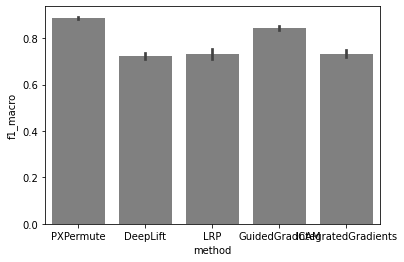

In [27]:
import seaborn as sns
sns.barplot(data = results_with_best_channels, 
            x = "method", 
            y = "f1_macro",
           palette = ["gray"])

In [28]:
results_with_best_channels.to_csv("results_with_best_channels.csv", index = True)